# ViennaRNA/Fornac

Below is an example of embedding ViennaRNA's [fornac](https://github.com/ViennaRNA/fornac) into jupyter as an ipywidget.

Some SHAPE data is plotted by numeric color onto "tRNA_phe_ecoli" from [(Weeks) data set](https://github.com/AviranLab/patteRNA/blob/a21f7dda56354d40817a87d0bc58a5a66f5ad7c1/sample_data/weeks_set.dot#L64-L66).

This should look like:

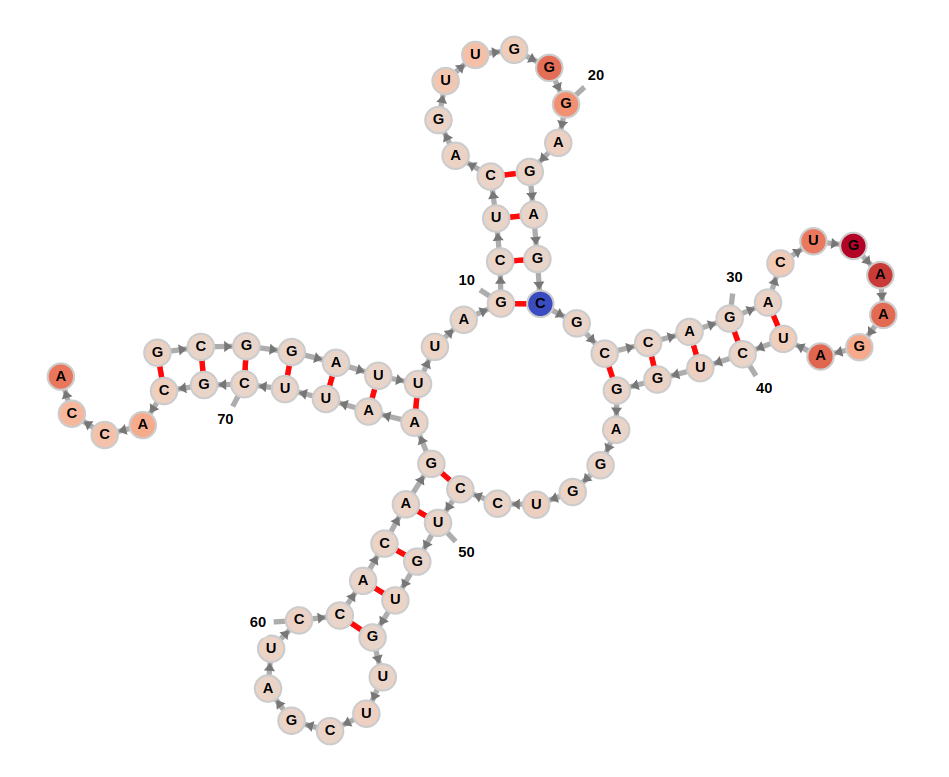

It's based on this (unused?) code I saw within [forgi](https://github.com/ViennaRNA/forgi/blob/0fca4a85bbe74f3e12cf1505e37a713c4454d34c/forgi/visual/fornac.py).

## Debugging
You might have to render the cell twice for it to update.

To update the version of "fornac" used, update the the stylesheet/javascript links used.

I used:
  - https://rawcdn.githack.com/ViennaRNA/fornac/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.css
  - https://rawcdn.githack.com/ViennaRNA/fornac/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.js

These correspond to viewing the "raw" files in the particular commit it was at the time:
  - https://github.com/ViennaRNA/fornac/blob/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.css
  - https://github.com/ViennaRNA/fornac/blob/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.js

("[Githack](https://raw.githack.com/faq)" lets those be linked to directly from an HTML snippet as though from a CDN. Services like this [tend to not last forever](https://rawgit.com/)--so you might have to use a different one in the future.)

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import Output, VBox
from IPython.display import display, HTML

import matplotlib
import IPython
import ipywidgets
print(f'Matplotlib: {matplotlib.__version__}')
print(f'IPython: {IPython.__version__}')
print(f'ipywidgets: {ipywidgets.__version__}')
!python -V

Matplotlib: 3.6.0
IPython: 7.27.0
ipywidgets: 8.0.2
Python 3.9.7


In [2]:

def scale_colors(colors_dict, cmap=None, reverse=False):
    '''
    A dictionary with values containing scalars which need to 
    be scaled according to some color map. The keys are irrelevant.
    The color map will be normalized to the range of values within 
    color_dict.
    :param colors_dict: The dictionary containing the values to be color scaled.
    :param cmap: A color map to be used to scale the colors.
    :param reverse: Reverse the color map
    :return: Another dictionary containing rgb triples as values.
    '''

    if cmap is None:
        import matplotlib.pyplot as plt
        cmap = plt.get_cmap('Blues')

    values = colors_dict.values()
    min_value = min(values)
    max_value = max(values)

    new_dict = {}
    for key in colors_dict:
        if reverse:
            color = cmap(
                1 - ((colors_dict[key] - min_value) / (max_value - min_value)))
        else:
            color = cmap(
                (colors_dict[key] - min_value) / (max_value - min_value))
        new_dict[key] = (int(255 * color[0]),
                         int(255 * color[1]), int(255 * color[2]))

    return new_dict

def nucleotide_colors_to_fornac_color_string(nucleotide_colors):
    '''
    Convert a dictionary of per nucleotide colors to a fornac
    color string.
    :param nucleotide_colors: A dictionary with nucleotide numbers as keys and colors as values.
                              (e.g. {1: (255,0,0), 2: (255,255,0)})
    :return: A color string (e.g "1:rgb(255,0,0) 2:rgb(255,0,0)")
    '''
    color_string = ""
    for key in nucleotide_colors:
        color_string += "{}:rgb({},{},{}) ".format(key, nucleotide_colors[key][0],
                                                   nucleotide_colors[key][1],
                                                   nucleotide_colors[key][2])

    return color_string

In [3]:
fornac_template = """
<!DOCTYPE html>
<link rel="stylesheet" type="text/css" href="https://rawcdn.githack.com/ViennaRNA/fornac/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.css" />
<script type="text/javascript" src="https://code.jquery.com/jquery-2.1.4.min.js"></script>
<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.6/d3.min.js"></script>
<script type="text/javascript" src="https://rawcdn.githack.com/ViennaRNA/fornac/99be5d18e34637e67d24d58e9bad5c1a5e3f133d/dist/fornac.js"></script>

<meta charset="utf-8">
<div id="rna_ss"></div>

<script type="text/javascript">
    // debugger;

    var container = new fornac.FornaContainer("#rna_ss", {{
        "applyForce": true, 
        "allowPanningAndZooming": true, 
        "initialSize": [500,500], 
        "cssFileLocation": "https://raw.githubusercontent.com/pkerpedjiev/fornac/master/css/fornac.css"
    }});

    var options = {{
        "sequence": "{seq}",
        "structure": "{struct}"
    }};
    container.addRNA(options.structure, options);

    var cs = fornac.ColorScheme("{color_str}");
    container.addCustomColors(cs.colorsJson);
    container.changeColorScheme("custom"); 
</script>
"""
def fornac_plot(seq, struct, shape_data):
    #cg = forgi_bg.BulgeGraph.from_dotbracket(seq=seq, dotbracket_str=struct)
    
    as_d = dict((i+1, v) for i,v in enumerate(shape_data))
    
    color_string = nucleotide_colors_to_fornac_color_string(
        scale_colors(as_d, cmap=plt.get_cmap('coolwarm')))
    fornac_html = fornac_template.format(seq=seq, struct=struct, color_str=color_string)
    out = Output()
    display(HTML(fornac_html))

    return VBox([out])

seq    = 'GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA'
struct = '(((((((..((((........)))).(((((.......))))).....(((((.......))))))))))))....'
shape_data = [0.049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.0, 0.0, 0.01, 0.039, 0.02, 0.205, 0.302, 0.127, 1.052, 0.779, 0.068, 0.01, 0.0, 0.0, -2, 0.01, 0.0, 0.01, 0.0, 0.0, 0.039, 0.175, 0.964, 1.607, 1.383, 1.081, 0.546, 1.11, 0.107, 0.01, 0.049, 0.029, 0.01, 0.01, 0.0, 0.01, 0.078, 0.01, 0.0, 0.0, 0.0, 0.02, 0.0, 0.01, 0.058, 0.01, 0.01, 0.01, 0.02, 0.029, 0.0, 0.0, 0.01, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.088, 0.536, 0.273, 0.409, 0.984]
fornac_plot(seq, struct, shape_data)